# Time Series Forecasting Project using ARIMA model 
## 1. Import Modules 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

## 2. Data download and inspection

In [10]:
raw_data_df=sns.load_dataset("flights")
raw_data_df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


### 2.1. Inspection 

In [11]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [12]:
raw_data_df.head().T

,0,1,2,3,4
year,1949,1949,1949,1949,1949
month,Jan,Feb,Mar,Apr,May
passengers,112,118,132,129,121


In [13]:
raw_data_df.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


### 2.2. Encode 'Month' and 'Year' features 

In [14]:
timeseries_df=raw_data_df.copy()
   
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month   
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))
timeseries_df=timeseries_df.set_index('date')
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [16]:
timeseries_df.head()

,dependent_var
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 3. EDA
### 3.1 Baseline Model performance 
#### 3.1.1 Linear Regression Model Baseline 

In [17]:
linear_model=LinearRegression()
x=np.array(range(len(timeseries_df))).reshape(-1, 1)
fit_result=linear_model.fit(x, timeseries_df['dependent_var'])
predictions=linear_model.predict(x)
timeseries_df['Linear model']=predictions
rmse=sqrt(mean_squared_error(timeseries_df['dependent_var'], predictions))
print(f'Linear model root mean square error: {rmse:.1f}')

Linear model root mean square error: 45.7


#### 3.1.2 'Carry forward' baseline 

In [18]:
predictions=timeseries_df['dependent_var'].to_numpy()[1:]
true_values=timeseries_df['dependent_var'].to_numpy()[0:-1]
rmse=sqrt(mean_squared_error(true_values, predictions))
print(f'Carry forward model root mean square error: {rmse:.1f}')

Carry forward model root mean square error: 33.7


### 3.2 Handle missing / extreme values 

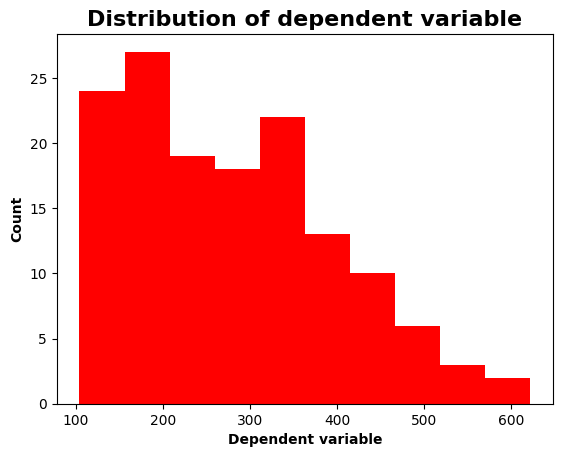

In [24]:
plt.title('Distribution of dependent variable', fontsize=16, fontweight='bold')
plt.hist(timeseries_df['dependent_var'], color='red', bins=10)
plt.xlabel('Dependent variable', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.show()

In [26]:
timeseries_df.head(12)

,dependent_var,Linear model
date,,
1949-01-01,112,90.309962
1949-02-01,118,92.967146
1949-03-01,132,95.624330
1949-04-01,129,98.281513
1949-05-01,121,100.938697
1949-06-01,135,103.595881
1949-07-01,148,106.253065
1949-08-01,148,108.910249
1949-09-01,136,111.567433


In [27]:
timeseries_df.describe()

,dependent_var,Linear model
count,144.000000,144.000000
mean,280.298611,280.298611
std,119.966317,110.839929
min,104.000000,90.309962
25%,180.000000,185.304286
50%,265.500000,280.298611
75%,360.500000,375.292936
max,622.000000,470.287261


#### 3.2.1 Time-series plot 

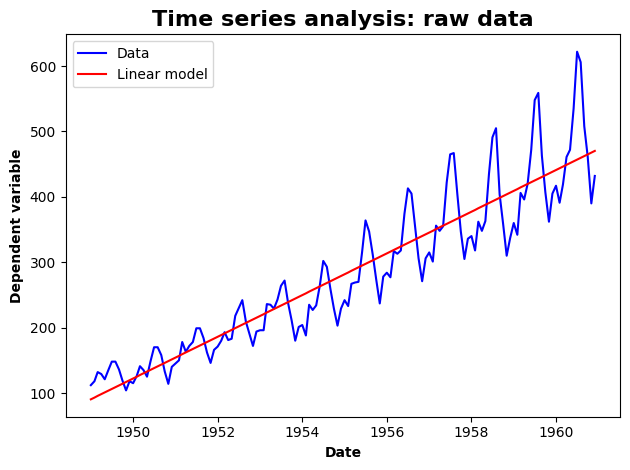

In [32]:
plt.title('Time series analysis: raw data', fontsize=16, fontweight='bold')
plt.plot(timeseries_df['dependent_var'], label='Data', color='blue')
plt.plot(timeseries_df['Linear model'], label='Linear model', color='red')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Dependent variable', fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### 3.2.2 Missing timepoints 

Datetime axis is regular: False

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


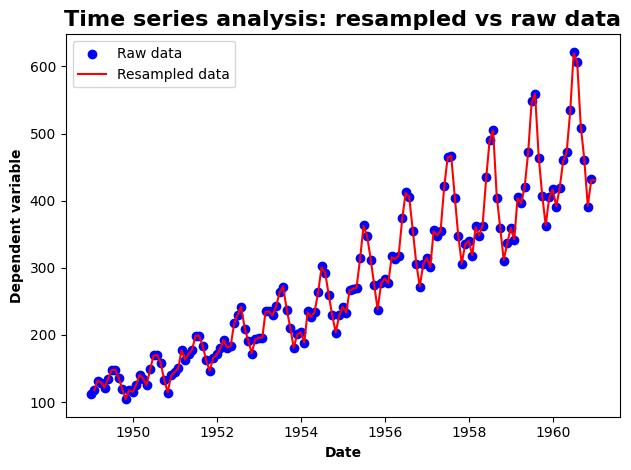

In [34]:
diff=np.diff(timeseries_df.index.to_numpy())
equally_spaced=np.all(diff==diff[0])
print(f'Datetime axis is regular: {equally_spaced}\n')

if equally_spaced == False:
    resampled_timeseries_df=timeseries_df.resample('D').interpolate()
    resampled_timeseries_df=resampled_timeseries_df.resample('ME').interpolate()
    resampled_timeseries_df.info()

    plt.title('Time series analysis: resampled vs raw data', fontsize=16, fontweight='bold')
    plt.scatter(timeseries_df.index, timeseries_df['dependent_var'], label='Raw data', color='blue')
    plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
    plt.xlabel('Date', fontweight='bold')
    plt.ylabel('Dependent variable', fontweight='bold')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    timeseries_df=resampled_timeseries_df

In [35]:
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


In [37]:
timeseries_df.head(12)

,dependent_var,Linear model
date,,
1949-01-31,117.806452,92.881430
1949-02-28,131.500000,95.529430
1949-03-31,129.096774,98.195798
1949-04-30,121.266667,100.850125
1949-05-31,134.548387,103.510166
1949-06-30,147.566667,106.164492
1949-07-31,148.000000,108.824533
1949-08-31,136.387097,111.481717
1949-09-30,119.566667,114.136044


#### 3.2.3 Stationarity 

In [38]:
dftest=adfuller(timeseries_df['dependent_var'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.984


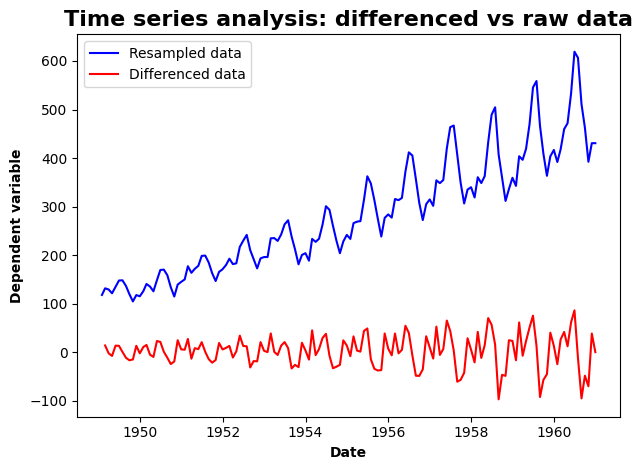

In [40]:
stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('Time series analysis: differenced vs raw data', fontsize=16, fontweight='bold')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='blue')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='red')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Dependent variable', fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()